Total rows for HNRNPK: 146
Nonsignificant    113
Downregulated      23
Upregulated        10
Name: significance, dtype: int64


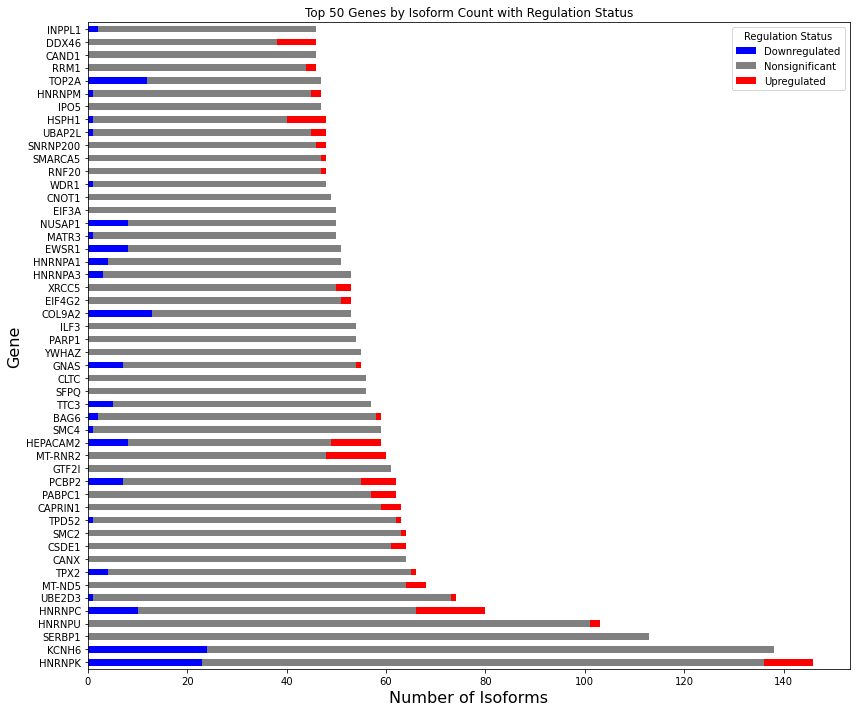

Nonsignificant    113
Downregulated      23
Upregulated        10
Name: significance, dtype: int64

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("input-files/isoform_de_data.csv")


lfc_threshold = 0
pval_threshold = 0.05

# Clean significance assignment
df["significance"] = "Nonsignificant"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] > lfc_threshold), "significance"] = "Upregulated"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] < -lfc_threshold), "significance"] = "Downregulated"

# Filter for that gene and count
gene = "HNRNPK"

# Get only rows for this gene
hnrnpk_df = df[df["associated_gene"] == gene]

# Check total rows
print("Total rows for HNRNPK:", hnrnpk_df.shape[0])

# Check value counts
print(hnrnpk_df["significance"].value_counts())

# Count isoforms per gene per significance category
counts = df.groupby(["associated_gene", "significance"]).size().unstack(fill_value=0)



# Add total column and get top 50
counts["total_isoforms"] = counts.sum(axis=1)
top = counts.sort_values("total_isoforms", ascending=False).head(50)

# Drop total for plotting and sort index to get top at top
plot_data = top.drop(columns="total_isoforms")
plot_data = plot_data[::-1]  # Reverse rows to have most isoforms at top of plot

# Color map
color_map = {"Upregulated": "red", "Downregulated": "blue", "Nonsignificant": "gray"}

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
plot_data.plot(kind="barh",
               stacked=True,
               color=[color_map[col] for col in plot_data.columns],
               ax=ax)

# Formatting
plt.gca().invert_yaxis()
ax.set_xlabel("Number of Isoforms", fontsize=16)
ax.set_ylabel("Gene", fontsize=16)
ax.set_title("Top 50 Genes by Isoform Count with Regulation Status")
ax.legend(title="Regulation Status", loc="upper right")

plt.tight_layout()
plt.show()


df[df["associated_gene"] == "HNRNPK"]["significance"].value_counts()

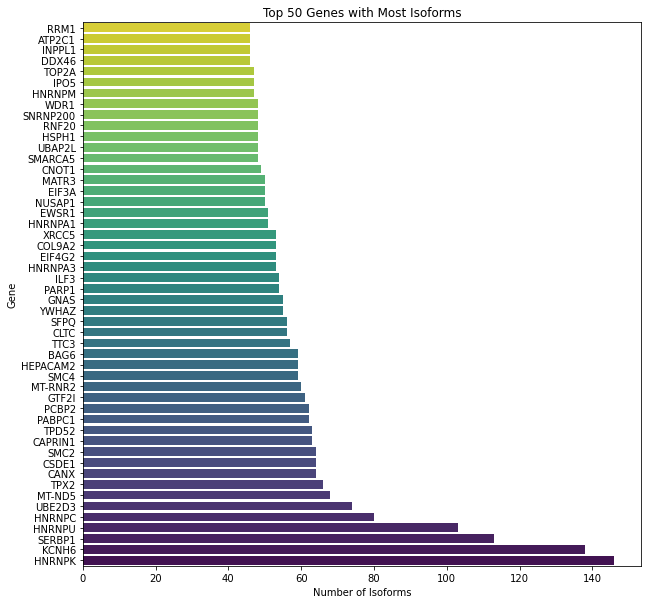

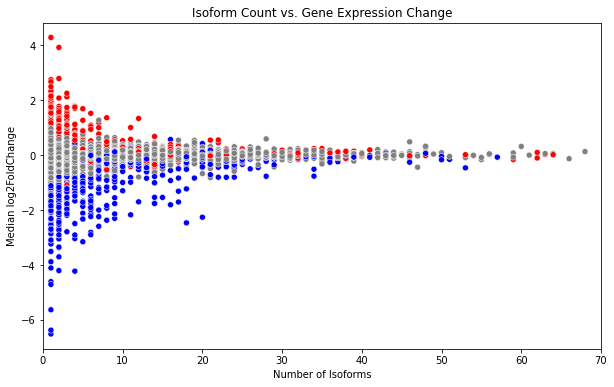

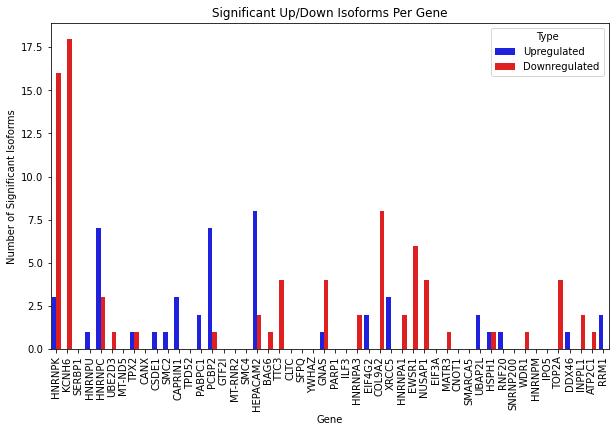

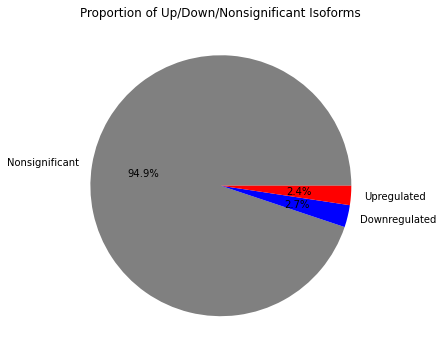

Total number of isoforms analyzed: 75734
Total number of genes analyzed: 10340
Upregulated genes: 9553, Downregulated genes: 7527, Both genes: 4418, Nonsignificant genes: 54236
Mean isoforms per gene: 7.32, Median: 4.0, Max: 146
Mean weighted LFC: -0.04, Median: 0.00, Range: (-6.514458998, 4.286011971)


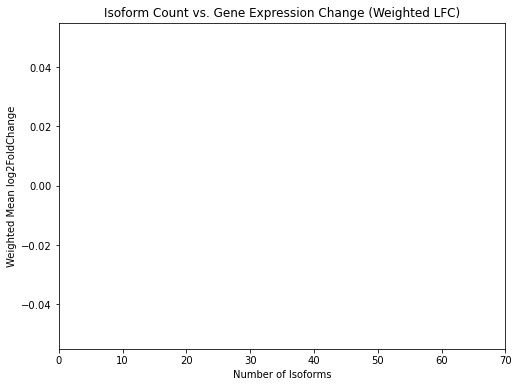

In [39]:
# Create a new column in the dataframe to classify the significance of each gene
df["gene_significance"] = "Nonsignificant"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] > lfc_threshold), "gene_significance"] = "Upregulated"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] < -lfc_threshold), "gene_significance"] = "Downregulated"

# Calculate median LFC and isoform count for each gene
gene_median_lfc = df.groupby("associated_gene")["log2FoldChange"].median()  # Use median LFC
isoform_counts = df.groupby("associated_gene")["log2FoldChange"].count()  # Count isoforms
gene_significance = df.groupby("associated_gene")["gene_significance"].first()  # Use the first significance label

# Create a scatter plot with coloring by significance
plt.figure(figsize=(10, 6))

# Define color mapping: Blue for upregulated, Red for downregulated, Gray for nonsignificant
color_map = {"Upregulated": "red", "Downregulated": "blue", "Nonsignificant": "gray"}

# Create scatter plot
sns.scatterplot(x=isoform_counts, y=gene_median_lfc, hue=gene_significance, palette=color_map, alpha=1.0, legend=None)

plt.xlabel("Number of Isoforms")
plt.ylabel("Median log2FoldChange")  # Update label to reflect median
plt.title("Isoform Count vs. Gene Expression Change")
plt.xlim(0, 70)  # Limit x-axis to 70 (or another value as needed)
plt.show()



# Plot 3: Stacked Bar Plot of Significant Isoforms Per Gene
top_genes_melted = top_genes[["Upregulated", "Downregulated"]].melt(ignore_index=False, var_name="Type", value_name="Count")
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genes_melted, x=top_genes_melted.index, y="Count", hue="Type", palette={"Upregulated": "blue", "Downregulated": "red"})
plt.xlabel("Gene")
plt.ylabel("Number of Significant Isoforms")
plt.xticks(rotation=90)
plt.title("Significant Up/Down Isoforms Per Gene")
plt.show()

# Plot 4: Pie Chart of Isoform Significance Categories
sig_counts = df["significance"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sig_counts, labels=sig_counts.index, autopct="%1.1f%%", colors=["gray", "blue", "red"])
plt.title("Proportion of Up/Down/Nonsignificant Isoforms")
plt.show()



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define thresholds
pval_threshold = 0.05
lfc_threshold = 1.0

# Create a new column in the dataframe to classify the significance of each gene
df["gene_significance"] = "Nonsignificant"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] > lfc_threshold), "gene_significance"] = "Upregulated"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] < -lfc_threshold), "gene_significance"] = "Downregulated"

# Calculate weighted mean LFC for each gene
gene_weighted_lfc = df.groupby("associated_gene").apply(
    lambda g: (g["log2FoldChange"] * g["baseMean"]).sum() / g["baseMean"].sum()
)

# Count the number of isoforms per gene
isoform_counts = df.groupby("associated_gene")["log2FoldChange"].count()

# Identify genes with both upregulated and downregulated isoforms
upregulated_genes = df[df["gene_significance"] == "Upregulated"]["associated_gene"].unique()
downregulated_genes = df[df["gene_significance"] == "Downregulated"]["associated_gene"].unique()

# Genes with both upregulated and downregulated isoforms
genes_with_both = set(upregulated_genes).intersection(downregulated_genes)

# Update gene significance to "Both" for those genes
df["gene_significance"] = df["associated_gene"].apply(lambda x: "Both" if x in genes_with_both else df.loc[df["associated_gene"] == x, "gene_significance"].iloc[0])

# Compute summary statistics
num_isoforms_total = len(df)
num_genes_total = len(gene_weighted_lfc)
num_upregulated = (df["gene_significance"] == "Upregulated").sum()
num_downregulated = (df["gene_significance"] == "Downregulated").sum()
num_both = (df["gene_significance"] == "Both").sum()
num_nonsignificant = (df["gene_significance"] == "Nonsignificant").sum()

mean_isoforms_per_gene = isoform_counts.mean()
median_isoforms_per_gene = isoform_counts.median()
max_isoforms_per_gene = isoform_counts.max()

mean_weighted_lfc = gene_weighted_lfc.mean()
median_weighted_lfc = gene_weighted_lfc.median()
lfc_range = (gene_weighted_lfc.min(), gene_weighted_lfc.max())

# Print summary statistics
print(f"Total number of isoforms analyzed: {num_isoforms_total}")
print(f"Total number of genes analyzed: {num_genes_total}")
print(f"Upregulated genes: {num_upregulated}, Downregulated genes: {num_downregulated}, Both genes: {num_both}, Nonsignificant genes: {num_nonsignificant}")
print(f"Mean isoforms per gene: {mean_isoforms_per_gene:.2f}, Median: {median_isoforms_per_gene}, Max: {max_isoforms_per_gene}")
print(f"Mean weighted LFC: {mean_weighted_lfc:.2f}, Median: {median_weighted_lfc:.2f}, Range: {lfc_range}")

# Create a scatter plot with coloring by significance
plt.figure(figsize=(8, 6))

# Define color mapping: Blue for upregulated, Red for downregulated, Green for both, Gray for nonsignificant
color_map = {"Upregulated": "red", "Downregulated": "blue", "Both": "green", "Nonsignificant": "gray"}

# Create scatter plot
sns.scatterplot(x=isoform_counts, y=gene_weighted_lfc, hue=df["gene_significance"], palette=color_map, alpha=1.0, legend="full")

plt.xlabel("Number of Isoforms")
plt.ylabel("Weighted Mean log2FoldChange")  # Updated label
plt.title("Isoform Count vs. Gene Expression Change (Weighted LFC)")
plt.xlim(0, 70)  # Limit x-axis to 70 (or another value as needed)
plt.show()

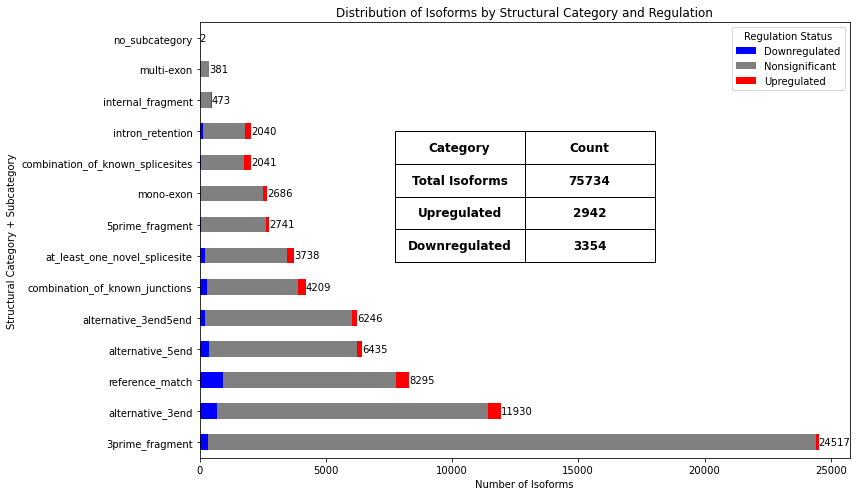

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("input-files/isoform_de_data.csv")

# Define thresholds
lfc_threshold = 0
pval_threshold = 0.05

# Create category column
#df["category"] = df["structural_category"] + " - " + df["subcategory"]

df["category"] = df["subcategory"]


# Classify isoforms based on significance
df["significance"] = "Nonsignificant"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] > lfc_threshold), "significance"] = "Upregulated"
df.loc[(df["padj"] < pval_threshold) & (df["log2FoldChange"] < -lfc_threshold), "significance"] = "Downregulated"

# Count occurrences for each category
category_counts = df.groupby(["category", "significance"]).size().unstack(fill_value=0)
category_counts = category_counts.loc[category_counts.sum(axis=1).sort_values(ascending=False).index]

# Colors
color_map = {"Nonsignificant": "gray", "Upregulated": "red", "Downregulated": "blue"}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))
category_counts.plot(kind="barh", stacked=True, color=[color_map[col] for col in category_counts.columns], ax=ax)

# Add labels for total isoforms per category
for i, (category, row) in enumerate(category_counts.iterrows()):
    total = row.sum()
    if total > 0:
        ax.text(total + 2, i, str(total), va='center', fontsize=10, color="black")

# Summary numbers
total_up = df[df["significance"] == "Upregulated"].shape[0]
total_down = df[df["significance"] == "Downregulated"].shape[0]
total_isoforms = df.shape[0]

# Add a table in the middle
table_data = [
    ["Total Isoforms", total_isoforms],
    ["Upregulated", total_up],
    ["Downregulated", total_down]
]
table = ax.table(cellText=table_data, colLabels=["Category", "Count"],
                 loc="center", cellLoc="center", bbox=[0.3, 0.45, 0.4, 0.3])  # Adjusted y-position

# Make the table text bold and increase font size significantly
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(fontweight='bold', fontsize=18)  # Much larger text
    if i == 0:  # Column headers
        cell.set_text_props(fontsize=20)  # Even larger font for headers


# Formatting
ax.set_xlabel("Number of Isoforms")
ax.set_ylabel("Structural Category + Subcategory")
ax.set_title("Distribution of Isoforms by Structural Category and Regulation")
ax.legend(title="Regulation Status")

plt.tight_layout()
plt.show()
